   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 62.3 MB/s eta 0:00:00


🔄 Loading CLIP model (openai/clip-vit-base-patch32) on cpu...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

📦 Indexing 50 products. Please wait...
✅ Indexing Complete!

 MULTI-MODAL PRODUCT SEARCH 
1. Search by Image Upload
2. Search by Text Description
3. Exit

Select an option (1-3): 1
📤 Please select an image file to upload:


Saving Kettle.webp to Kettle.webp
🔍 Searching for matching products...

--- VISUAL SEARCH: KETTLE.WEBP ---


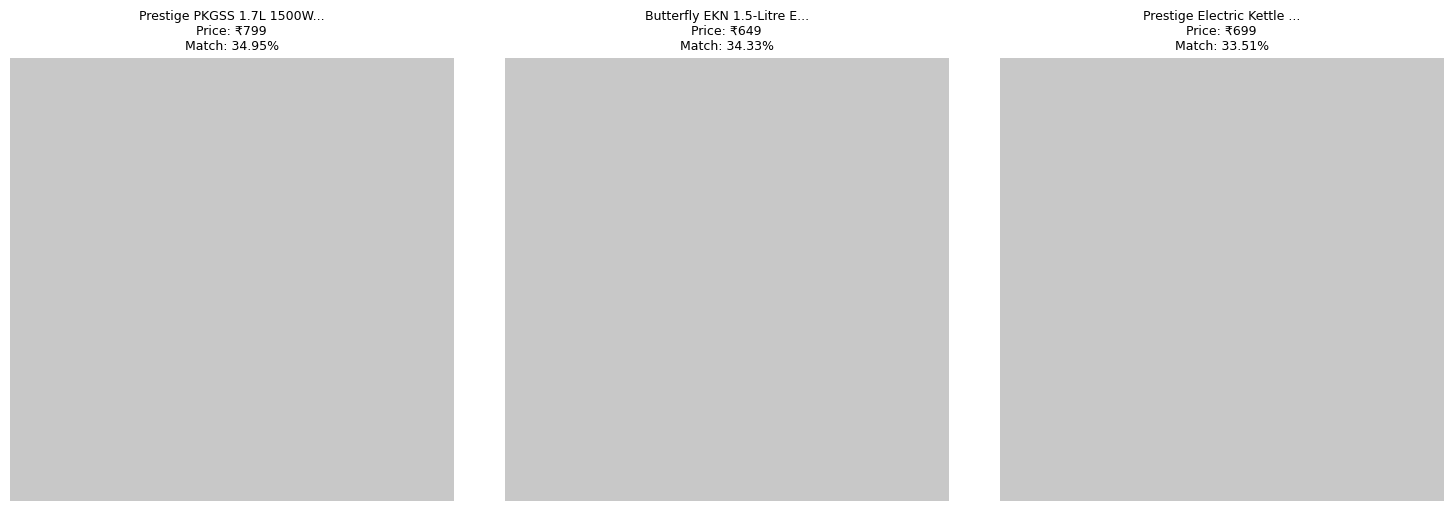


 MULTI-MODAL PRODUCT SEARCH 
1. Search by Image Upload
2. Search by Text Description
3. Exit

Select an option (1-3): 3
👋 Exiting. Have a great day!


In [1]:
# =================================================================
# PRODUCTION-STYLE MULTI-MODAL SEARCH (CLIP + FAISS)
# Dataset: All Appliances.csv
# =================================================================

# 1. Install required libraries
!pip install -q transformers torch faiss-cpu pillow requests

import pandas as pd
import torch
import numpy as np
import faiss
import requests
import io
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from transformers import CLIPProcessor, CLIPModel
from google.colab import files
from IPython.display import display, clear_output

# --- CONFIGURATION ---
CSV_FILE = "All Appliances.csv"
MODEL_NAME = "openai/clip-vit-base-patch32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TOP_K = 3  # Number of products to return
NUM_SAMPLES = 50 # Number of items to index for the demo

# --- CORE SEARCH ENGINE ---
class MultiModalSearchEngine:
    def __init__(self, model_name, device):
        print(f"🔄 Loading CLIP model ({model_name}) on {device}...")
        self.device = device
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.embedding_dim = self.model.config.projection_dim
        self.index = None
        self.metadata = []

    def _get_embedding(self, text=None, image=None):
        """Generates normalized embeddings for text or image."""
        if text:
            inputs = self.processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(self.device)
            with torch.no_grad():
                features = self.model.get_text_features(**inputs)
        elif image:
            inputs = self.processor(images=image, return_tensors="pt").to(self.device)
            with torch.no_grad():
                features = self.model.get_image_features(**inputs)

        # Normalize for Cosine Similarity
        features = features / features.norm(dim=-1, keepdim=True)
        return features.cpu().numpy().astype('float32')

    def build_index(self, df):
        """Downloads images and builds the vector search index."""
        print(f"📦 Indexing {len(df)} products. Please wait...")
        self.metadata = df.to_dict('records')
        self.index = faiss.IndexFlatIP(self.embedding_dim) # Inner Product on normalized = Cosine Sim

        embeddings = []
        headers = {"User-Agent": "Mozilla/5.0"}

        for i, item in enumerate(self.metadata):
            try:
                # 1. Process Image
                response = requests.get(item['image'], headers=headers, timeout=5)
                img = Image.open(io.BytesIO(response.content)).convert("RGB")
                self.metadata[i]['img_obj'] = img
                img_emb = self._get_embedding(image=img)

                # 2. Process Text (Name + Category)
                text_data = f"{item['name']} {item['sub_category']}"
                text_emb = self._get_embedding(text=text_data)

                # 3. Hybrid Representation (Average of modalities)
                combined_emb = (img_emb + text_emb) / 2
                combined_emb = combined_emb / np.linalg.norm(combined_emb)
                embeddings.append(combined_emb)

            except Exception:
                # Fallback to text-only if image fails
                placeholder = Image.new('RGB', (200, 200), color=(200, 200, 200))
                self.metadata[i]['img_obj'] = placeholder
                embeddings.append(self._get_embedding(text=item['name']))

        self.index.add(np.vstack(embeddings))
        print("✅ Indexing Complete!")

    def search(self, query_type, query_val):
        """Performs search based on text string or PIL Image."""
        if query_type == "text":
            q_emb = self._get_embedding(text=query_val)
        else:
            q_emb = self._get_embedding(image=query_val)

        distances, indices = self.index.search(q_emb, TOP_K)

        results = []
        for i, idx in enumerate(indices[0]):
            results.append({
                "product": self.metadata[idx],
                "score": float(distances[0][i])
            })
        return results

# --- UI HELPER ---
def show_results(results, title):
    """Displays results in a clean grid format."""
    print(f"\n--- {title.upper()} ---")
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1: axes = [axes]

    for i, res in enumerate(results):
        p = res['product']
        axes[i].imshow(p['img_obj'])
        info = f"{p['name'][:25]}...\nPrice: {p.get('discount_price', 'N/A')}\nMatch: {res['score']:.2%}"
        axes[i].set_title(info, fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    display(plt.gcf()) # Explicitly display the figure
    plt.close()

# --- MAIN EXECUTION ---
def main():
    try:
        if not os.path.exists(CSV_FILE):
            print(f"❌ Error: '{CSV_FILE}' not found. Please upload it to the left sidebar.")
            return

        # Load data
        df = pd.read_csv(CSV_FILE).head(NUM_SAMPLES)

        # Initialize Engine
        engine = MultiModalSearchEngine(MODEL_NAME, DEVICE)
        engine.build_index(df)

        while True:
            print("\n" + "="*30)
            print(" MULTI-MODAL PRODUCT SEARCH ")
            print("="*30)
            print("1. Search by Image Upload")
            print("2. Search by Text Description")
            print("3. Exit")

            choice = input("\nSelect an option (1-3): ").strip()

            if choice == '1':
                print("📤 Please select an image file to upload:")
                uploaded = files.upload()
                if uploaded:
                    file_name = list(uploaded.keys())[0]
                    query_img = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")
                    print("🔍 Searching for matching products...")
                    results = engine.search("image", query_img)
                    show_results(results, f"Visual Search: {file_name}")

            elif choice == '2':
                query_text = input("💬 Enter product description (e.g. 'Silver kettle'): ")
                if query_text:
                    print(f"🔍 Searching for '{query_text}'...")
                    results = engine.search("text", query_text)
                    show_results(results, f"Text Search: {query_text}")

            elif choice == '3':
                print("👋 Exiting. Have a great day!")
                break
            else:
                print("⚠️ Invalid selection. Please try again.")

    except Exception as e:
        print(f"❗ A system error occurred: {e}")

if __name__ == "__main__":
    main()

In [ ]:
# 1. INSTALL NECESSARY LIBRARIES
!pip install -q transformers torch faiss-cpu pillow requests

import pandas as pd
import torch
import numpy as np
import faiss
import requests
import io
import re
import os
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from google.colab import files
from IPython.display import display, HTML, clear_output

# --- CONFIGURATION ---
CSV_FILE = "All Appliances.csv"
MODEL_NAME = "openai/clip-vit-base-patch32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_SAMPLES = 100 # Adjust this number to index more or fewer products

# --- CORE UTILITIES ---

def extract_asin_image(url):
    """
    Extracts the ASIN from an Amazon URL and returns a high-res image URL.
    This fulfills the requirement to retrieve images from the link column.
    """
    try:
        # Regex to find ASIN (10 character alphanumeric code)
        match = re.search(r'/(?:dp|gp/product)/([A-Z0-9]{10})', url)
        if match:
            asin = match.group(1)
            # High-resolution Amazon image pattern
            return f"https://images-na.ssl-images-amazon.com/images/P/{asin}.01.LZZZZZZZ.jpg"
    except:
        pass
    return "https://via.placeholder.com/300?text=Image+Not+Found"

class ApplianceSearchSystem:
    def __init__(self):
        print(f"🔄 Initializing CLIP Model on {DEVICE}...")
        self.model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
        self.processor = CLIPProcessor.from_pretrained(MODEL_NAME)
        self.dim = self.model.config.projection_dim
        self.index = None
        self.data = []

    def _get_text_embedding(self, text):
        inputs = self.processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        with torch.no_grad():
            emb = self.model.get_text_features(**inputs)
        return (emb / emb.norm(dim=-1, keepdim=True)).cpu().numpy().astype('float32')

    def _get_image_embedding(self, image):
        inputs = self.processor(images=image, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            emb = self.model.get_image_features(**inputs)
        return (emb / emb.norm(dim=-1, keepdim=True)).cpu().numpy().astype('float32')

    def build_index(self, df):
        print(f"📦 Indexing {len(df)} products (Text-based logic)...")
        self.data = df.to_dict('records')
        self.index = faiss.IndexFlatIP(self.dim)

        embeddings = []
        for item in self.data:
            # Combine name and categories for a rich search vector
            text_content = f"{item['name']} {item['main_category']} {item['sub_category']}"
            embeddings.append(self._get_text_embedding(text_content))

        self.index.add(np.vstack(embeddings))
        print("✅ System Ready.")

    def search(self, query, is_image=False):
        try:
            q_vec = self._get_image_embedding(query) if is_image else self._get_text_embedding(query)
            distances, indices = self.index.search(q_vec, 3) # Top 3 results

            results = []
            for i, idx in enumerate(indices[0]):
                results.append({
                    "info": self.data[idx],
                    "score": float(distances[0][i])
                })
            return results
        except Exception as e:
            print(f"❌ Search Error: {e}")
            return []

def display_results(results):
    """Render products in a clean, clear HTML grid."""
    html = "<div style='display: flex; flex-wrap: wrap; gap: 20px; justify-content: center;'>"
    for res in results:
        p = res['info']
        img_url = extract_asin_image(p['link'])
        name = p['name']
        price = p.get('discount_price', 'N/A')
        actual = p.get('actual_price', '')

        html += f"""
        <div style="width: 280px; border: 1px solid #ddd; border-radius: 12px; padding: 15px; background: white; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
            <div style="height: 250px; display: flex; align-items: center; justify-content: center; overflow: hidden;">
                <img src="{img_url}" style="max-width: 100%; max-height: 100%; object-fit: contain;" onerror="this.src='https://via.placeholder.com/250?text=Image+Unavailable'">
            </div>
            <div style="margin-top: 15px; text-align: left;">
                <h4 style="font-size: 14px; color: #333; height: 45px; overflow: hidden; margin: 0;">{name[:70]}...</h4>
                <p style="margin: 10px 0 5px 0;">
                    <span style="font-size: 18px; font-weight: bold; color: #B12704;">{price}</span>
                    <span style="font-size: 12px; text-decoration: line-through; color: #777; margin-left: 8px;">{actual}</span>
                </p>
                <a href="{p['link']}" target="_blank" style="display: inline-block; padding: 6px 12px; background: #FFD814; color: #111; text-decoration: none; border-radius: 4px; font-size: 12px; font-weight: bold;">View Details</a>
            </div>
        </div>
        """
    html += "</div>"
    display(HTML(html))

# --- MAIN EXECUTION ---

def run_search_app():
    if not os.path.exists(CSV_FILE):
        print(f"❌ Error: {CSV_FILE} not found. Please upload the file to your Colab environment.")
        return

    try:
        # Load and sample the dataset
        df = pd.read_csv(CSV_FILE).fillna('')
        # Filter for products with valid links
        df = df[df['link'].str.contains('amazon.in', na=False)]

        app = ApplianceSearchSystem()
        app.build_index(df.head(NUM_SAMPLES))

        while True:
            print("\n" + "="*50)
            print("        APPLIANCE MULTI-MODAL SEARCH ENGINE")
            print("="*50)
            print("1. Search by Image (Upload)")
            print("2. Search by Text")
            print("3. Exit")

            choice = input("\nEnter Choice (1/2/3): ").strip()

            if choice == '1':
                print("📤 Please upload an image...")
                uploaded = files.upload()
                if uploaded:
                    fname = list(uploaded.keys())[0]
                    query_img = Image.open(io.BytesIO(uploaded[fname])).convert("RGB")
                    print("\n🔎 Searching for visually similar products...")
                    results = app.search(query_img, is_image=True)
                    display_results(results)

            elif choice == '2':
                query_text = input("💬 Describe the appliance you want: ")
                if query_text:
                    print(f"\n🔎 Searching for '{query_text}'...")
                    results = app.search(query_text, is_image=False)
                    display_results(results)

            elif choice == '3':
                print("👋 Exiting system. Goodbye!")
                break
            else:
                print("⚠️ Invalid choice. Please enter 1, 2, or 3.")

    except Exception as e:
        print(f"❗ A critical error occurred: {e}")

# START
run_search_app()

🔄 Initializing CLIP Model on cpu...
📦 Indexing 100 products (Text-based logic)...
✅ System Ready.

        APPLIANCE MULTI-MODAL SEARCH ENGINE
1. Search by Image (Upload)
2. Search by Text
3. Exit

Enter Choice (1/2/3): 1
📤 Please upload an image...


Saving Kettle.webp to Kettle (1).webp

🔎 Searching for visually similar products...



        APPLIANCE MULTI-MODAL SEARCH ENGINE
1. Search by Image (Upload)
2. Search by Text
3. Exit

Enter Choice (1/2/3): 2
💬 Describe the appliance you want: washing machine

🔎 Searching for 'washing machine'...



        APPLIANCE MULTI-MODAL SEARCH ENGINE
1. Search by Image (Upload)
2. Search by Text
3. Exit

Enter Choice (1/2/3): 1
📤 Please upload an image...


Saving Kettle.webp to Kettle (2).webp

🔎 Searching for visually similar products...



        APPLIANCE MULTI-MODAL SEARCH ENGINE
1. Search by Image (Upload)
2. Search by Text
3. Exit
